[*********************100%***********************]  3 of 3 completed


Value at Risk for Tesla (95% confidence): -0.06406939934017672


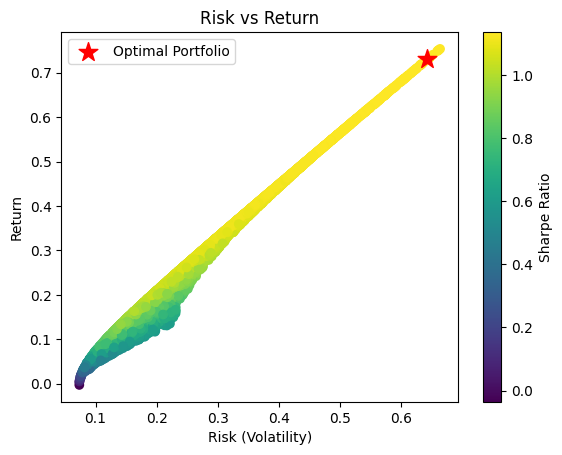

Optimal Portfolio Weights:
TSLA: 0.0000
BND: 0.0684
SPY: 0.9316
Expected Annual Return: 73.00%
Portfolio Volatility: 64.26%
Sharpe Ratio: 1.14


In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load historical data for TSLA, BND, and SPY
assets = ['TSLA', 'BND', 'SPY']
data = yf.download(assets, start='2020-01-01', end='2024-01-01')['Adj Close']

# Display first few rows of the data
data.head()

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate annual returns and covariance matrix
annual_returns = daily_returns.mean() * 252
cov_matrix = daily_returns.cov() * 252

# Display the annual returns and covariance matrix
annual_returns, cov_matrix

# Define number of assets
num_assets = len(assets)

# Portfolio performance function: returns, volatility, and Sharpe ratio
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(weights * mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = returns / volatility
    return returns, volatility, sharpe_ratio

# Optimization function: minimize negative Sharpe ratio
def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    return -portfolio_performance(weights, mean_returns, cov_matrix)[2]

# Constraints (weights sum to 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds for each asset (between 0 and 1)
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess (even weights)
initial_guess = [1. / num_assets] * num_assets

# Perform optimization to find the optimal portfolio weights
optimized_result = minimize(negative_sharpe_ratio, initial_guess, args=(annual_returns, cov_matrix), 
                            method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimized_result.x

# Portfolio statistics for the optimal portfolio
optimal_return, optimal_volatility, optimal_sharpe_ratio = portfolio_performance(optimal_weights, annual_returns, cov_matrix)

# Calculate the Value at Risk (VaR) at 95% confidence level for TSLA
VaR = np.percentile(daily_returns['TSLA'], 5)
print(f"Value at Risk for Tesla (95% confidence): {VaR}")

# Generate random portfolios for risk-return visualization
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    portfolio_return, portfolio_volatility, _ = portfolio_performance(weights, annual_returns, cov_matrix)
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe ratio

# Plot Risk vs Return
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.title('Risk vs Return')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, marker='*', color='r', s=200, label='Optimal Portfolio')
plt.legend()
plt.show()

# Display the results
print("Optimal Portfolio Weights:")
for i, asset in enumerate(assets):
    print(f"{asset}: {optimal_weights[i]:.4f}")

print(f"Expected Annual Return: {optimal_return * 100:.2f}%")
print(f"Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.2f}")

# Save results to CSV
weights_df = pd.DataFrame(optimal_weights, index=assets, columns=['Weight'])
weights_df.to_csv('optimized_portfolio_weights.csv')
